In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150

In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("/home/jovyan/git/rsm-mgta455-intuit/data/intuit75k.pkl")
intuit75k["res1_yes"] = (intuit75k["res1"] == "Yes").astype(int)
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


In [3]:
# show dataset description
rsm.describe(intuit75k)

## Intuit: Quickbooks upgrade

The purpose of this exercise is to gain experience modeling the response to an upsell campaign. The `intuit75k.rds` file contains data on 75,000 (small) businesses that were selected randomly from the 801,821 that were sent the wave-1 mailing. The mailing contained an offer to upgrade to the latest version of the Quickbooks software. 

Variable `res1` denotes which of these businesses responded to the mailing by purchasing Quickbooks version 3.0 from Intuit Direct. Note that Intuit Direct sells products directly to its customers rather than through a retailer. Use the available data to predict which businesses that did not respond to the wave-1 mailing, are most likely to respond to the wave-2 mailing. Note that variables were added, deleted, and recoded so please ignore the variable descriptions in Exhibit 3 in the case in the course reader. Instead, use the variable descriptions below:

## Variable description

* id: Small business customer ID
* zip: 5-

For our RFM models, we need to create RFM bins for IQ and SQ. For IQ, we have grouped by recency, frequency and monetary variables independently whereas for SQ we first group by Recency then Frequency followed by Monetary

In [4]:
##RFM Independent Bins
intuit75k = intuit75k.assign(rec_iq=rsm.xtile(intuit75k["last"], 5))
intuit75k = intuit75k.assign(freq_iq=rsm.xtile(intuit75k["numords"], 5, rev=True))
intuit75k = intuit75k.assign(mon_iq=rsm.xtile(intuit75k["dollars"], 5, True))
intuit75k = intuit75k.assign(
    rfm_iq=intuit75k["rec_iq"].astype(str)
    + intuit75k["freq_iq"].astype(str)
    + intuit75k["mon_iq"].astype(str)
)

In [5]:
#RFM Sequential Bins
intuit75k = intuit75k.assign(freq_sq=intuit75k.groupby("rec_iq")["numords"].transform(rsm.xtile, 5, rev=True))
intuit75k = intuit75k.assign(mon_sq=intuit75k.groupby(["rec_iq", "freq_sq"])["dollars"].transform(rsm.xtile, 5, rev=True))
intuit75k = intuit75k.assign(
    rfm_sq=intuit75k["rec_iq"].astype(str)
    + intuit75k["freq_sq"].astype(str)
    + intuit75k["mon_sq"].astype(str)
)

In [6]:
##Creating Training and test dataset
intuit_training= intuit75k[intuit75k['training']==1].reset_index()
intuit_test= intuit75k[intuit75k['training']==0].reset_index()

In [7]:
#Calculating Response rates
intuit_training['res1_yes'].agg(n_mails= "count",n_responders=sum)

n_mails         52500
n_responders     2498
Name: res1_yes, dtype: int64

In [8]:
#Overall Response Rate
resp_rate= (np.nanmean(intuit_training['res1_yes'] == 1)*100).round(2).astype(str)
print("The percentage of customers who responded to wave_1 emails is " + resp_rate + "%")

The percentage of customers who responded to wave_1 emails is 4.76%


In [9]:
#Calculating Breakeven rate
cost= 1.41
margin= 60
breakeven_rr= cost/margin
print("The breakeven response rate for wave_1 emails is "+ str(round(breakeven_rr*100,2))+ "%")

The breakeven response rate for wave_1 emails is 2.35%


We now need to compare response rate per RFM bin with breakeven rate and only contact the users who have response rate greater than 0.0235. In the below codes we do the analysis for rfm_iq, rfm_sq, rfm_iq_lb, rfm_sq_lb. We also target variable for each model to extract the RFM cell IDs that we need to contact

In [10]:
# Find cells to target on test dataset based on breakeven
groups_iq= intuit_training.groupby("rfm_iq")["res1_yes"].agg((lambda x: (np.nanmean(x == 1))/2)).reset_index()
target_iq=groups_iq[groups_iq['res1_yes']>breakeven_rr]['rfm_iq']
groups_sq= intuit_training.groupby("rfm_sq")["res1_yes"].agg((lambda x: (np.nanmean(x == 1))/2)).reset_index()
target_sq=groups_sq[groups_sq['res1_yes']>breakeven_rr]['rfm_sq']

In [11]:
#Find cells to target for Lowerbound IQ analysis and response rate per bin
intuit_lbiq = (
    intuit_training.groupby("rfm_iq")["res1_yes"]
    .agg(n_obs="count", prop=np.mean, se=rsm.seprop)
    .reset_index()
)
intuit_lbiq = intuit_lbiq.assign(prop_iq_lb=(intuit_lbiq["prop"] - 1.64 * intuit_lbiq["se"])/2)
target_lb_rfm_iq= intuit_lbiq[intuit_lbiq['prop_iq_lb']>breakeven_rr]['rfm_iq']

In [12]:
#Find cells to target for Lowerbound SQ analysis and response rate per bin
intuit_lbsq = (
    intuit_training.groupby("rfm_sq")["res1_yes"]
    .agg(n_obs="count", prop=np.mean, se=rsm.seprop)
    .reset_index()
)
intuit_lbsq = intuit_lbsq.assign(prop_sq_lb=(intuit_lbsq["prop"] - 1.64 * intuit_lbsq["se"])/2)
target_lb_rfm_sq= intuit_lbsq[intuit_lbsq['prop_sq_lb']>breakeven_rr]['rfm_sq']

In [13]:
#Defining profit, ROME calculation function that will  be used for all the 4 models
def perf_calc(notify, intro, target):
    notify= intuit_test[intuit_test[notify].isin(target)]
    nr_notify = notify.shape[0]
    perc_notify= nr_notify/22500
    nr_resp = notify[notify['res1_yes']==1].shape[0]
    rep_rate= nr_resp/nr_notify
    marginal_cost = 1.41 * nr_notify
    revenue =  nr_resp*60
    profit_nt = revenue - marginal_cost
    ROME_nt = profit_nt / marginal_cost
    print(f"""Intuit would email to {int(nr_notify):,} ({round((100 * perc_notify), 2)}%) customers. The response rate for the selected customers is {round((100 * rep_rate), 2)}% or {int(nr_resp):,} buyers. The revenue is equal to ${int(revenue):,}. The profit is ${int(profit_nt):,}. The marginal cost is ${int(marginal_cost):,} with a ROME of {round((100 * ROME_nt), 2)}%""")
    return profit_nt, ROME_nt

In [14]:
#RFM IQ Analysis
profit_iq, ROME_iq= perf_calc(notify="rfm_iq", intro="Based on independent RFM", target= target_iq)

Intuit would email to 9,235 (41.04%) customers. The response rate for the selected customers is 7.56% or 698 buyers. The revenue is equal to $41,880. The profit is $28,858. The marginal cost is $13,021 with a ROME of 221.63%


In [15]:
#RFM SQ Analysis
profit_iq, ROME_iq= perf_calc(notify="rfm_sq", intro="Based on independent RFM", target= target_sq)

Intuit would email to 9,272 (41.21%) customers. The response rate for the selected customers is 7.56% or 701 buyers. The revenue is equal to $42,060. The profit is $28,986. The marginal cost is $13,073 with a ROME of 221.72%


In [16]:
#RFM IQ lower bound analysis
profit_iq_lb, ROME_iq_lb= perf_calc(notify="rfm_iq", intro="Based on independent RFM and adjusting for standard error", target= target_lb_rfm_iq)

Intuit would email to 5,111 (22.72%) customers. The response rate for the selected customers is 9.22% or 471 buyers. The revenue is equal to $28,260. The profit is $21,053. The marginal cost is $7,206 with a ROME of 292.15%


In [17]:
#RFM SQ lower bound analysis
profit_iq_lb, ROME_iq_lb= perf_calc(notify="rfm_sq", intro="Based on independent RFM and adjusting for standard error", target= target_lb_rfm_sq)

Intuit would email to 4,563 (20.28%) customers. The response rate for the selected customers is 9.18% or 419 buyers. The revenue is equal to $25,140. The profit is $18,706. The marginal cost is $6,433 with a ROME of 290.75%


In [18]:
#RFM Cells to target for all the 4 models
intuit_test['target_iq_cells']= np.where(intuit_test["rfm_iq"].isin(target_iq),1,0)
intuit_test['target_sq_cells']= np.where(intuit_test["rfm_sq"].isin(target_sq),1,0)
intuit_test['target_iq_lb_cells']= np.where(intuit_test["rfm_iq"].isin(target_lb_rfm_iq),1,0)
intuit_test['target_sq_lb_cells']= np.where(intuit_test["rfm_sq"].isin(target_lb_rfm_sq),1,0)

In [19]:
#Response rate per bin for iq
x= intuit_test.groupby('rfm_iq')['res1_yes'].agg(n_users="count", n_response=sum)
x['iq_response_rate']= x['n_response']/x['n_users']
intuit_test= intuit_test.merge(x['iq_response_rate'], on='rfm_iq')

In [20]:
#Response rate per bin for sq
x= intuit_test.groupby('rfm_sq')['res1_yes'].agg(n_users="count", n_response=sum)
x['sq_response_rate']= x['n_response']/x['n_users']
intuit_test= intuit_test.merge(x['sq_response_rate'], on='rfm_sq')

In [21]:
#Response rate per bin for lower iq
intuit_test= intuit_test.merge(intuit_lbiq[['prop_iq_lb','rfm_iq']], on='rfm_iq')

In [22]:
#Response rate per bin for lower sq
intuit_test= intuit_test.merge(intuit_lbsq[['prop_sq_lb','rfm_sq']], on='rfm_sq')

<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative gains'>

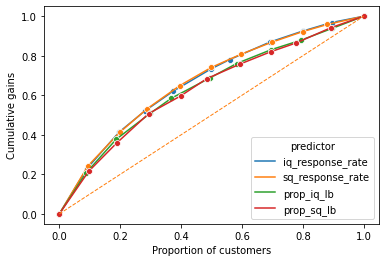

In [23]:
#Gains chart
rsm.gains_plot(df=intuit_test, rvar='res1_yes', lev=1, pred= ['iq_response_rate','sq_response_rate','prop_iq_lb','prop_sq_lb'], qnt=10, marker="o")

<AxesSubplot:xlabel='Proportion of customers', ylabel='Profit'>

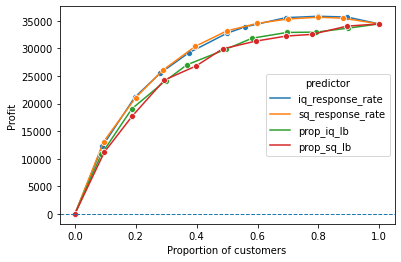

In [24]:
#Profit Curve
rsm.profit_plot(df=intuit_test, rvar='res1_yes', lev=1, pred= ['iq_response_rate','sq_response_rate','prop_iq_lb','prop_sq_lb'] ,qnt=10, cost=1.41, margin=60)

<AxesSubplot:xlabel='Proportion of customers', ylabel='Cumulative lift'>

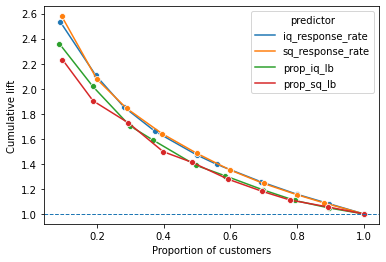

In [25]:
#Lift plot
rsm.lift_plot(df=intuit_test,rvar='res1_yes',lev=1,pred=['iq_response_rate','sq_response_rate','prop_iq_lb','prop_sq_lb'])

<AxesSubplot:xlabel='Proportion of customers', ylabel='Return on Marketing Expenditures (ROME)'>

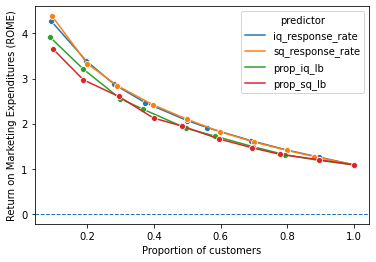

In [26]:
#ROME plot
rsm.ROME_plot(df=intuit_test,rvar='res1_yes',lev=1,pred=['iq_response_rate','sq_response_rate','prop_iq_lb','prop_sq_lb'], cost=1.41,margin=60)